Formation OpenClassrooms DS-IML

**Projet 2**

Par **Marc Lefèvre**, <marc.lefevre@noos.fr>

# ANALYSE DE DONNÉES EXPLORATOIRE : Open Food Facts

## 2ème Partie

# Analyses Univariées & Nettoyage des données

Récupération des données et chargement des bibliothèques Python que nous allons utiliser.

In [112]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
df = pd.read_csv("Data/df_red1.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443749 entries, 0 to 1443748
Data columns (total 36 columns):
code                                       1443749 non-null object
url                                        1443749 non-null object
countries_en                               1441453 non-null object
product_name                               1378190 non-null object
generic_name                               104368 non-null object
brands                                     795370 non-null object
categories                                 743518 non-null object
main_category_en                           743516 non-null object
labels                                     337305 non-null object
ingredients_text                           640108 non-null object
pnns_groups_1                              1429255 non-null object
pnns_groups_2                              1443143 non-null object
allergens                                  168478 non-null object
additives_en           

## Analyse succinte des variables qualitatives *texte*

Nous avons observé que les champs textes de nos variables étaient soit composées d'un mot, soit d'expressions de plusieurs mots, soit de plusieurs mots ou expressions séparés par des virgules. Nous allons nous contenter, pour l'instant, d'observer les distributions du nombre de **mots uniques** dans ces variables.<br><br>Les mots et expressions auront été au préalable, grâce à la fonction ci-dessous :<br>- Passés en minuscules<br>- Débarassés de préfixes **"en:"** ou **"fr:"** qu'on a pu remarquer dans certaines variables<br>- Regroupés dans des suites de mots uniques séparés entre eux par des *espaces*.

In [114]:
# Fonction de mise en forme    
def conv_suite_mots(s):
  
    liste = s.lower().split(", ")
    new = []
    for w in liste :
        w = w.lstrip("en:")
        w = w.lstrip("fr:")
        new.append(w)
    new = list(set(new))
    return " ".join(new)

Boucle de création des histogrammes

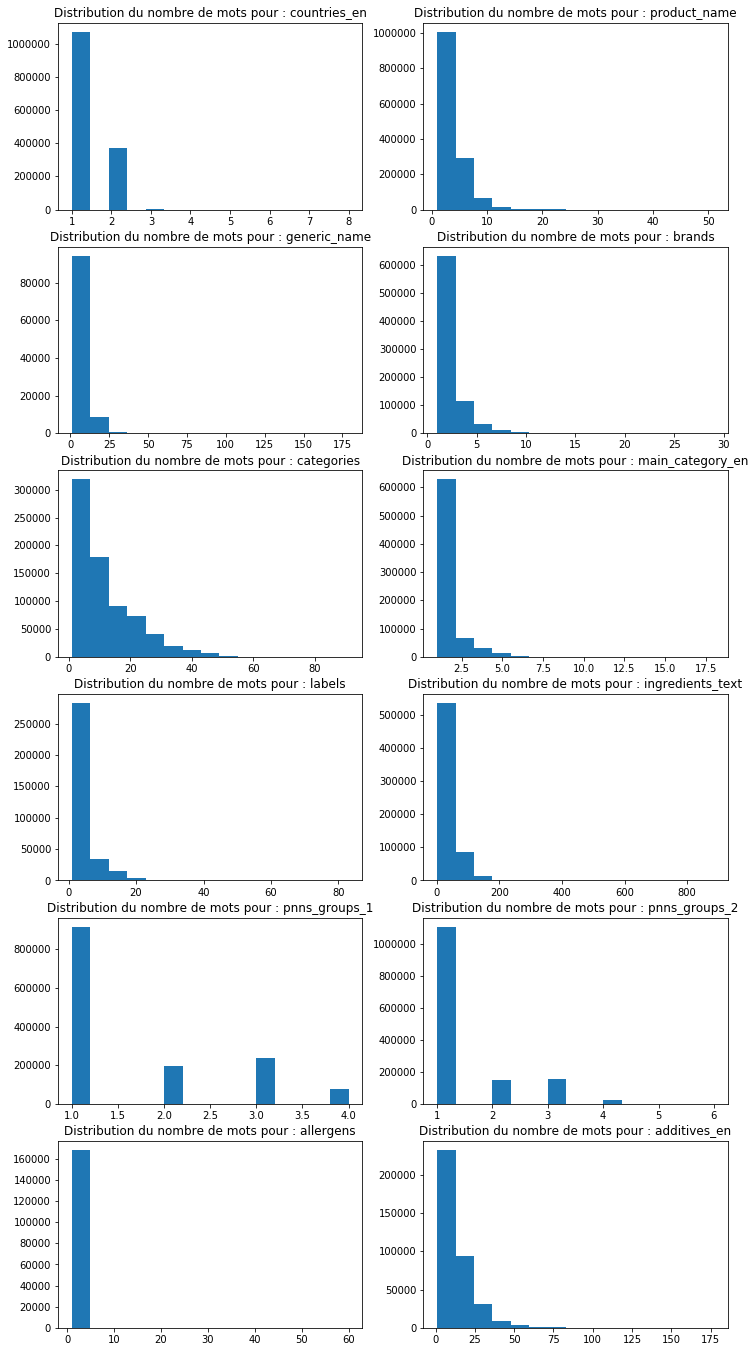

In [115]:
plt.figure(figsize=(12,24))
i=1
for col in df.columns[2:14]:    
    new_serie = df[col][df[col].notnull()].map(conv_suite_mots)
    mots = new_serie.str.split(" ").apply(lambda x: len(x))
    plt.subplot(6,2,i)
    plt.hist(mots, bins=15)
    plt.title(f'Distribution du nombre de mots pour : {col}')
    i+=1
plt.show()

On peut remarquer qu'il existe parfois d'importantes disparités, au sein d'une même variable, dans la façon dont cette variable a été renseignées.
Si on regarde par exemple **"categories"** :

In [116]:
df.categories.value_counts()

Snacks                                                                                                                                                                                                                                                                       32705
Snacks, Sweet snacks, Confectioneries                                                                                                                                                                                                                                        14372
Groceries, Sauces                                                                                                                                                                                                                                                            13937
Dairies, Fermented foods, Fermented milk products, Cheeses                                                                                                                     

On voit par exemple nettement que cette description sera parfois un peu anarchique. A cet égard, la variable "soeur" **"main_catagory_en"** semble beaucoup plus homogène.<br>Dans le même type de variable qualitatives, les deux colonnes **"PNNS"** (pour *Programme National Nutrition Santé*), qui proposent des classements catégoriels des produits, semble aussi avoir été renseignées de manière exhaustives et homogène.<br>Sauf qu'à y regarder de plus près, la principale valeur renseignée est **"unknown/inconnu"**.

In [117]:
df.pnns_groups_1.value_counts()

unknown                    846785
Sugary snacks              124263
Milk and dairy products     75719
Fish Meat Eggs              71092
Cereals and potatoes        67965
Fat and sauces              59303
Beverages                   58850
Composite foods             46629
Fruits and vegetables       39838
Salty snacks                27654
fruits-and-vegetables        6780
sugary-snacks                4315
cereals-and-potatoes           57
salty-snacks                    5
Name: pnns_groups_1, dtype: int64

## Variables quantitatives discontinues

Observons nos quatre variables suivantes.

In [118]:
df[df.columns[14:18]].describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nova_group
count,640108.000000,640108.000000,640108.000000,556104.000000
mean,2.010467,0.020811,0.069804,3.439808
std,2.846657,0.144587,0.302400,0.954755
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,3.000000
50%,1.000000,0.000000,0.000000,4.000000
75%,3.000000,0.000000,0.000000,4.000000
max,49.000000,3.000000,6.000000,4.000000


Si les trois autres ne semblent pas montrer d'irrégularités, nous avons manifestement des **outliers** dans la variable **"additives_n"**. Ce qui est confirmé par la ***boxplot*** de la variable.

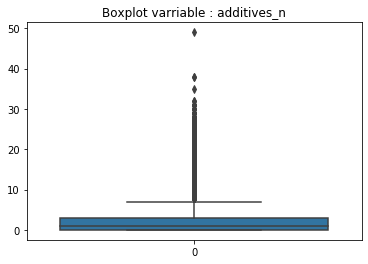

In [119]:
sns.boxplot(data=df["additives_n"])
plt.title("Boxplot varriable : additives_n")
plt.show()

Nous décidon d'éliminer les observations, que nous considérons comme aberrantes, dont les valeurs pour cette variable seront **supérieures à 30**.

In [120]:
df = df[(df.additives_n.isnull()) | (df.additives_n <= 30)]

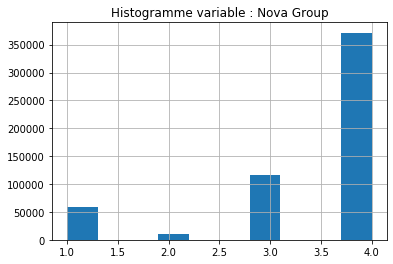

In [121]:
df.nova_group.hist()
plt.title("Histogramme variable : Nova Group")
plt.show()

La variable **Nova Group**, qui est un *indice de transformation des aliments* (avec des valeurs allant de 1 à 4 du moins au plus transformé), semble correctemment renseignée. Par contre il est intéressant de voir que pour environ les deux tiers des produits renseignés, l'indice est maximum...

## Nutriscore :  score & grade

La valeur numérique du **Nutriscore**, c'est à dire la variable **"nutriscore_score"**, dont on peut trouver le détail des calculs et les modalités ici :<br>https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/qr-scientifique-technique-en<br>est une valeur numérique comprise entre **-15** et **40**.

In [122]:
df[df.columns[18:19]].describe()

,nutriscore_score
count,582888.000000
mean,9.173872
std,8.914258
min,-15.000000
25%,1.000000
50%,10.000000
75%,16.000000
max,40.000000


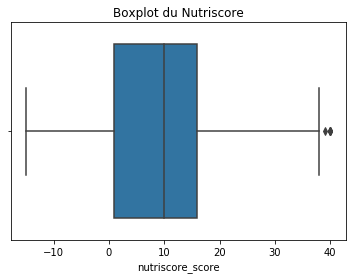

In [123]:
plt.title("Boxplot du Nutriscore")
sns.boxplot(df["nutriscore_score"])
plt.show()

Rien d'irrégulier repéré avec cette variable.

Quand au Classement Nutriscore, une apprécition sous forme de lettre **A, B, C, D** ou **E**, il est donné par la variable **"nutriscore_grade"**.

In [124]:
df.nutriscore_grade.value_counts()

d    180667
c    122401
e    110512
a     94450
b     74858
Name: nutriscore_grade, dtype: int64

Toutes les valeurs renseignées correspondent bien à ce qui est attendu. On peut même observer visuellement la répartition des valeurs dans un diagramme circulaire.

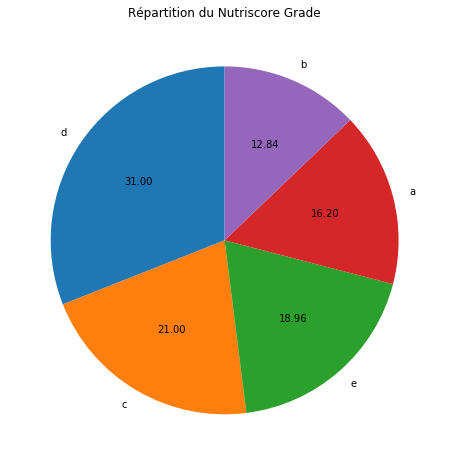

In [125]:
plt.figure(figsize = (8,8))
plt.title('Répartition du Nutriscore Grade')
plt.pie(df["nutriscore_grade"].value_counts(), autopct='%.2f', labels = df["nutriscore_grade"].value_counts().index, 
        startangle=90)
plt.show()

## Variables quantitatives continues

### Les valeurs énergétiques

In [126]:
df[df.columns[20:22]].describe()

,energy-kcal_100g,energy_100g
count,1.094588e+06,1.163787e+06
mean,7.944650e+06,5.727473e+36
std,8.309733e+09,6.178739e+39
min,0.000000e+00,0.000000e+00
25%,1.010000e+02,4.180000e+02
50%,2.640000e+02,1.092000e+03
75%,4.000000e+02,1.674000e+03
max,8.693855e+12,6.665559e+42


Avec ces deux variables représentants l'apports énergétique des produits concernés, la première en **kcal**, la seconde en **kj** (on rappelle que **1 kcal = 4,1868 kJ**), on se rend bien compte que nous sommes en présence d'**outliers** assez extrêmes. L'ordre de grandeur de l'énergie, en kcal , apportée par 100g de nourriture, est la centaine *10e2*. En kj, on peut attendre le millier, **10e3**.<br>Avec ici des énergies de l'ordre de **10e12** (presque l'énergie dégagée par une bombe atomique) et **10e42** (10e30 bombes atomiques), nous sommes en présence d'outliers, de "pics", absurdement grands.<br>On remarquera au passage que valeurs moyennes et écarts-types sont particulièrement sensibles à ce type d'outliers extrêmes, contrairement à la valeur médianne et autres quantiles.

Nous fixons deux seuils. le premier de **1500** pour **"energy-kcal_100g"** et le second de **6200** pour **"energy_100g"** au dessus desquels nous décidons d"effacer les observations.

In [127]:
df = df[(df["energy-kcal_100g"].isnull()) | (df["energy-kcal_100g"] <= 1500)]
df = df[(df["energy_100g"].isnull()) | (df["energy_100g"] <= 6200)]

### Données nutritionnelles

In [104]:
df[df.columns[22:]].describe()

,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
count,1.154314e+06,1.107517e+06,263906.000000,267892.000000,1.153769e+06,1.132713e+06,445648.000000,1.155561e+06,1.134194e+06,1.134188e+06,211765.000000,219315.000000,268490.000000,263852.000000
mean,1.381776e+01,1.227972e+08,0.046624,0.046948,2.850028e+01,1.386378e+01,2.940046,8.447330e+00,2.020392e+00,8.082373e-01,0.003606,0.024591,0.170963,0.006437
std,1.716352e+02,1.292301e+11,1.062256,1.459121,2.856274e+01,2.008667e+01,5.000061,1.274796e+01,1.410913e+02,5.643721e+01,0.507444,0.754790,7.849096,0.266173
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,-1.000000e+00,-20.000000,-5.000000e+02,0.000000e+00,0.000000e+00,-0.000340,0.000000,0.000000,-0.000260
25%,6.000000e-01,1.000000e-01,0.000000,0.000000,3.570000e+00,7.000000e-01,0.000000,1.200000e+00,6.000000e-02,2.400000e-02,0.000000,0.000000,0.000000,0.000000
50%,6.900000e+00,1.900000e+00,0.000000,0.000000,1.570000e+01,3.900000e+00,1.552778,5.800000e+00,5.350000e-01,2.140000e-01,0.000000,0.000000,0.036000,0.001000
75%,2.142857e+01,7.220000e+00,0.000000,0.022000,5.357000e+01,2.000000e+01,3.600000,1.200000e+01,1.353820e+00,5.415280e-01,0.000107,0.004000,0.109000,0.002400
max,1.536795e+05,1.360000e+14,369.000000,300.000000,2.916670e+03,1.350000e+03,439.000000,8.466000e+03,1.050000e+05,4.200000e+04,126.000000,100.000000,3400.000000,50.000000


Toutes ces données représentent une masse de quelque chose (graisse, sucre, etc.) pour 100g du produit concerné.<br>Nous avons donc une règle toute faite pour traiter une grande partie des **outliers** de celles-ci :<br>Nous pouvons nous séparer des observations dont les valeurs sont soit **négatives**, soit **supérieures à 100**.

In [128]:
for col in df.columns[22:]:
    df = df[(df[col].isnull()) | (df[col] >= 0)]
    df = df[(df[col].isnull()) | (df[col] <= 100)]

On peut maintenant observer nos variables après cette premier nettoyage.

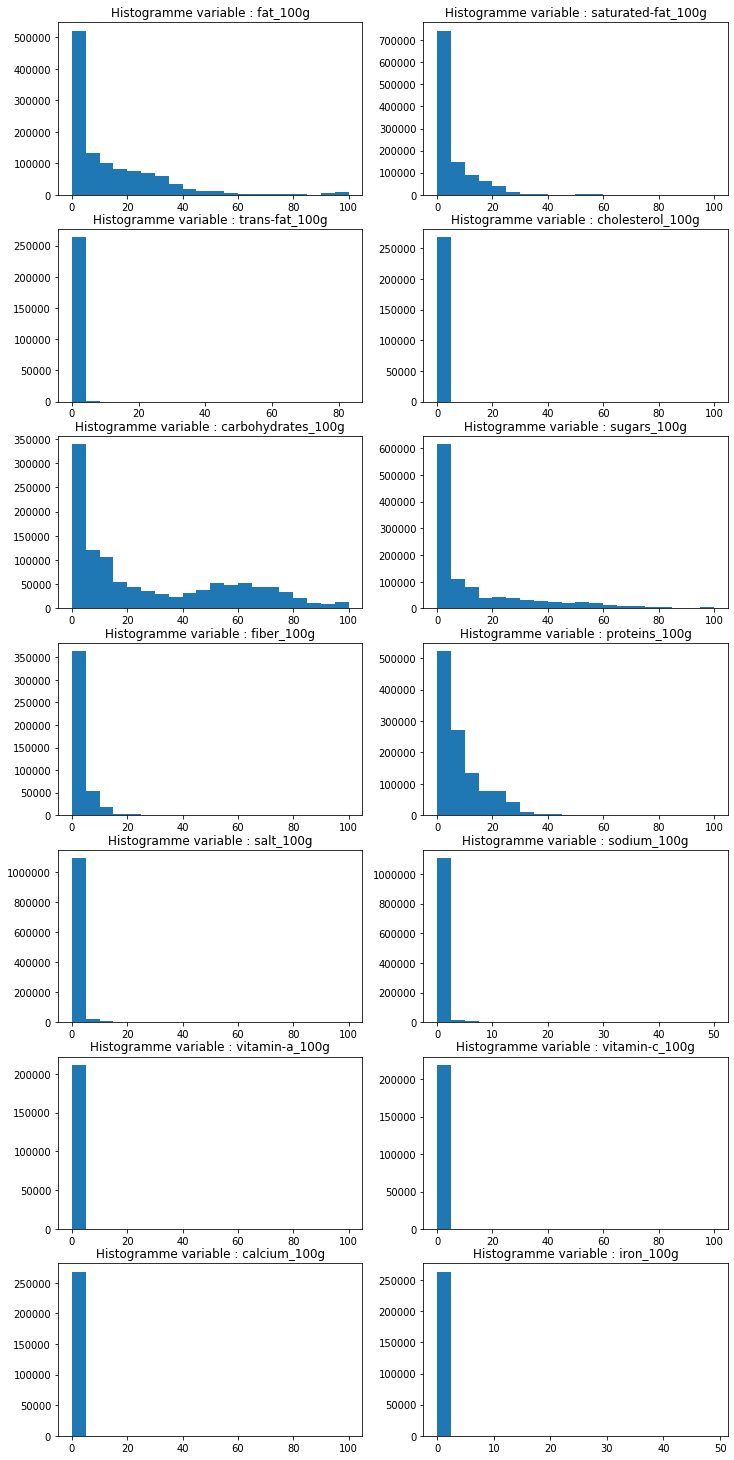

In [129]:
plt.figure(figsize=(12,26))
i=1
for col in df.columns[22:]:    
    plt.subplot(7,2,i)
    plt.hist(df[col], bins=20)
    plt.title(f'Histogramme variable : {col}')
    i+=1
plt.show()

Avant de passer à la suite, nous sauvegardons notre dataset sous le nom de **df_red2.csv**.

In [130]:
df.to_csv("Data/df_red2.csv", index=False)

Fin de la **2ème partie**.